In [ ]:
!pip install shap==0.46.0

In [1]:
# prompt: MOUNT

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
# ======================= Load Data =======================

df_metabolites = pd.read_csv("/content/drive/MyDrive/MY THESIS/Thesis/metabolites_training.csv")


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
import seaborn as sns
import shap

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
import tensorflow as tf

In [ ]:
# ======================= Load Data =======================

df_metabolites = pd.read_csv("/content/drive/MyDrive/THESIS/metabolites_training.csv")


In [ ]:
# ======================= Encode Target Variable =======================
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_metabolites["TNBC_Subtype"])
X = df_metabolites.drop(columns=["TNBC_Subtype"]).values

# ======================= Standardize Features =======================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X).astype(np.float32)  # Ensure float32

# ======================= Train-Test Split =======================
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Reshape for LSTM (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1])).astype(np.float32)
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1])).astype(np.float32)

# ======================= Build LSTM Model =======================
def build_lstm(X_train):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001))))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Bidirectional(LSTM(64, return_sequences=False, kernel_regularizer=l2(0.001))))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.3))

    model.add(Dense(len(np.unique(y)), activation='softmax'))

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=Adam(learning_rate=1e-4),
        metrics=['accuracy']  # Only accuracy
    )
    return model

# ======================= Train Model =======================
model = build_lstm(X_train)

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=150, batch_size=252,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping, lr_scheduler])



Epoch 1/150
112/112 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.3506 - loss: 2.4864 - val_accuracy: 0.6730 - val_loss: 2.1078 - learning_rate: 1.0000e-04
Epoch 2/150
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.6105 - loss: 1.8097 - val_accuracy: 0.7713 - val_loss: 1.8161 - learning_rate: 1.0000e-04
Epoch 3/150
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.6967 - loss: 1.5871 - val_accuracy: 0.8091 - val_loss: 1.4424 - learning_rate: 1.0000e-04
Epoch 4/150
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7378 - loss: 1.4463 - val_accuracy: 0.8279 - val_loss: 1.2132 - learning_rate: 1.0000e-04
Epoch 5/150
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7630 - loss: 1.3573 - val_accuracy: 0.8373 - val_loss: 1.1249 - learning_rate: 1.0000e-04
Epoch 6/150
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7789 - loss: 1.2923 - val_accuracy: 0.8459 - val_loss: 1.0796 - learning_rate: 1.0000e-04
Epoch 7/150
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/st

221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Classification Report:
                                 precision    recall  f1-score   support

             Basal-like 1 (BL1)       0.91      0.89      0.90      1434
             Basal-like 2 (BL2)       0.89      0.88      0.88      1490
Luminal Androgen Receptor (LAR)       0.91      0.91      0.91      1924
                Mesenchymal (M)       0.90      0.92      0.91      2208

                       accuracy                           0.90      7056
                      macro avg       0.90      0.90      0.90      7056
                   weighted avg       0.90      0.90      0.90      7056



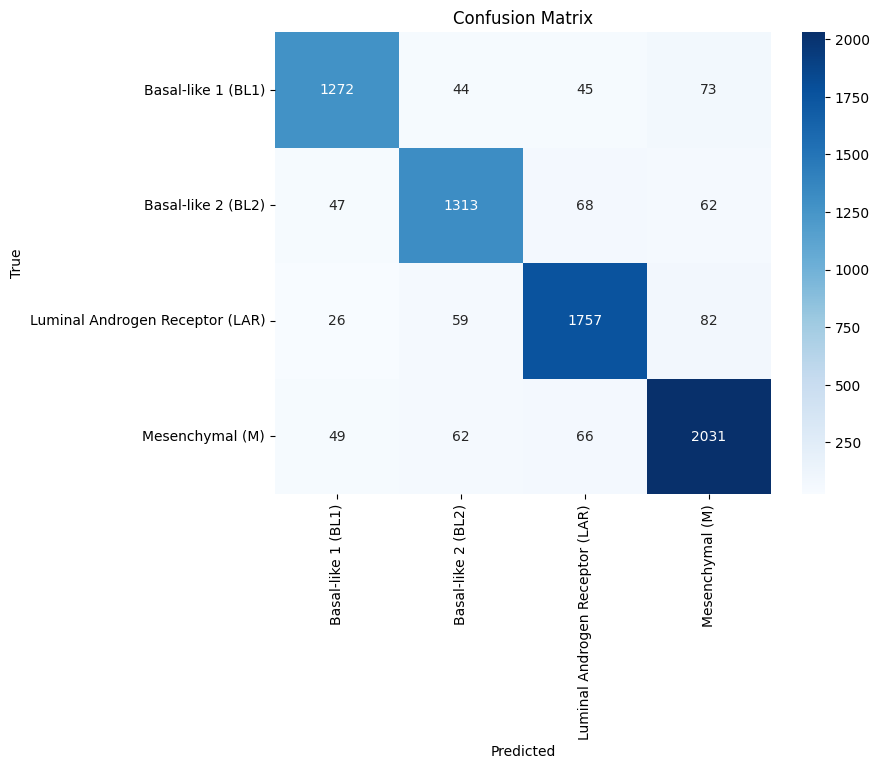

Accuracy: 0.903202947845805
Precision: 0.9032214212816498
Recall: 0.903202947845805
F1 Score: 0.9031471605389146


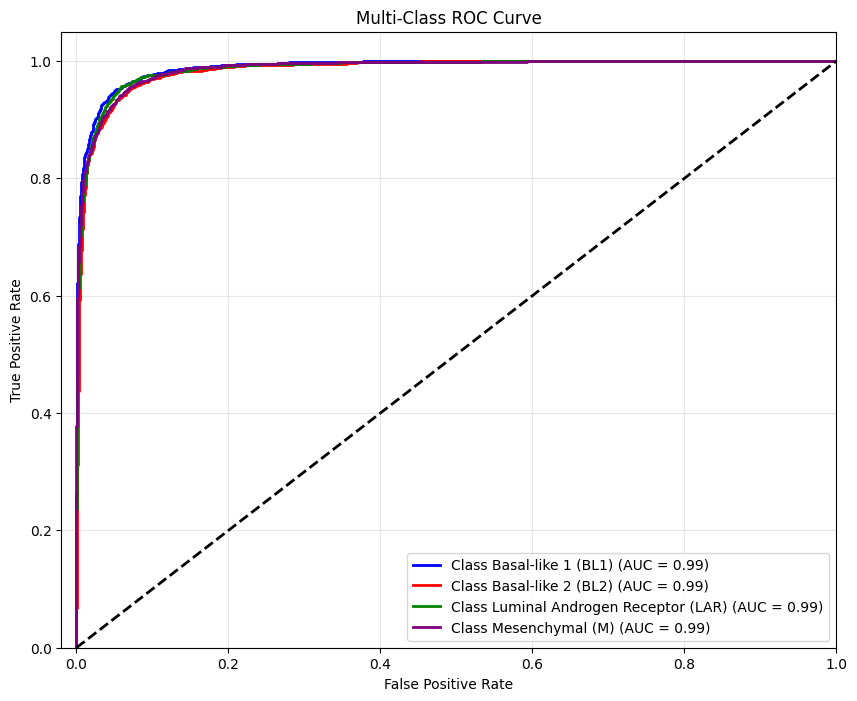


Macro-Averaged AUC: 0.9874


In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# ======================= Evaluate Model =======================
y_pred = np.argmax(model.predict(X_test), axis=1)
y_pred_proba = model.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt='d',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Additional Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))

# ======================= ROC-AUC & Curve =======================
n_classes = len(label_encoder.classes_)
y_test_one_hot = label_binarize(y_test, classes=range(n_classes))
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_one_hot[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'purple', 'orange', 'cyan'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"Class {label_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# Print overall macro/micro AUC
macro_auc = roc_auc_score(y_test_one_hot, y_pred_proba, average='macro', multi_class='ovr')
print(f"\nMacro-Averaged AUC: {macro_auc:.4f}")


In [ ]:
import shap

# Flatten input for SHAP (LSTM expects 3D, but SHAP needs 2D for KernelExplainer)
X_test_flat = X_test.reshape((X_test.shape[0], -1))
X_train_flat = X_train.reshape((X_train.shape[0], -1))

# Define prediction function
def predict_fn(x):
    x_reshaped = x.reshape((x.shape[0], 1, X_train.shape[2]))  # reshape back to 3D
    return model.predict(x_reshaped)

# Use a small background dataset for KernelExplainer
background = X_train_flat[np.random.choice(X_train_flat.shape[0], 100, replace=False)]
explainer = shap.KernelExplainer(predict_fn, background)

# Use a small sample for SHAP computation to avoid high computation time
X_shap_sample = X_test_flat[:50]

# Compute SHAP values
shap_values = explainer.shap_values(X_shap_sample)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
6832/6832 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
6832/6832 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
6832/6832 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
6832/6832 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
6832/6832 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
6832/6832 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6832/6832 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
6832/6832 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
6832/6832 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
6832/6832 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
6832/6832 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
6832/6832 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step
1/1 ━━━━━━━━━━━━


Class 0: Basal-like 1 (BL1)


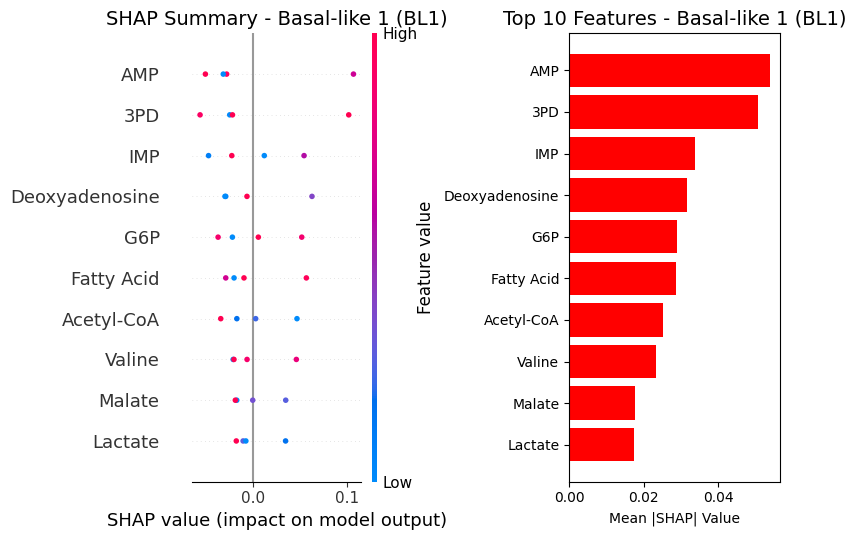


Class 1: Basal-like 2 (BL2)


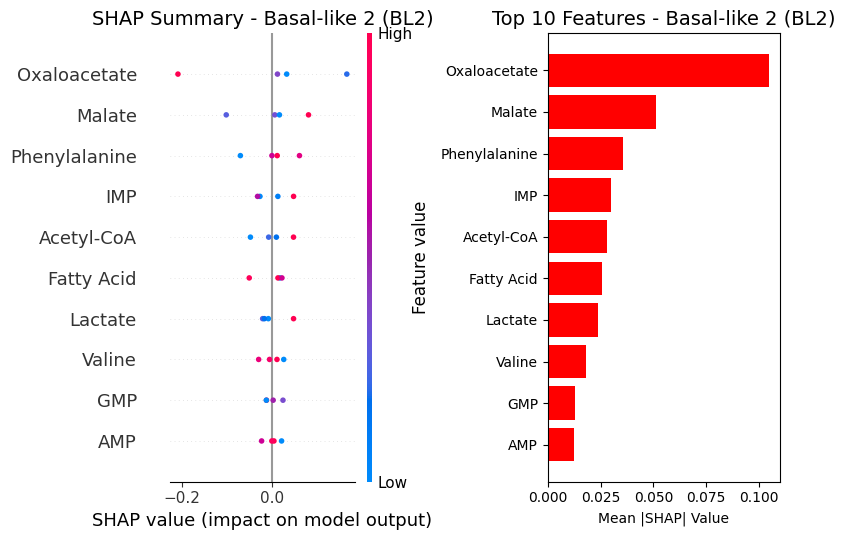


Class 2: Luminal Androgen Receptor (LAR)


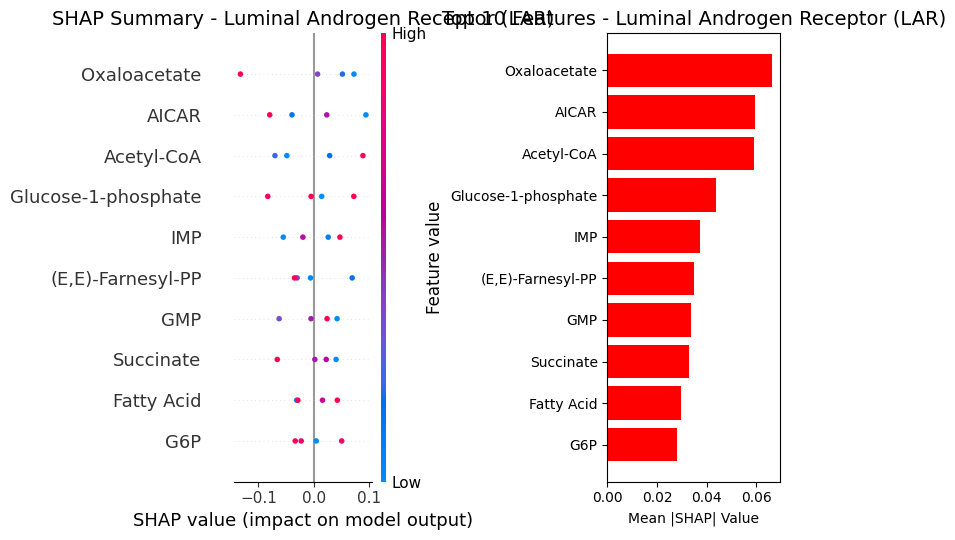


Class 3: Mesenchymal (M)


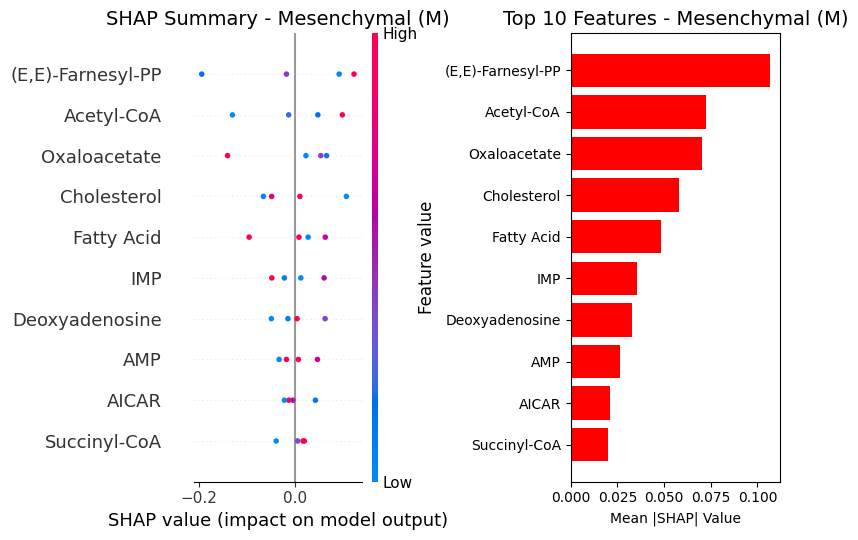

In [ ]:
# Flatten your SHAP input sample
X_shap_sample = X_test[:4]
X_shap_sample_flat = X_shap_sample.reshape((X_shap_sample.shape[0], X_shap_sample.shape[2]))  # (4, 69)

feature_names = df_metabolites.drop("TNBC_Subtype", axis=1).columns.tolist()

# Loop through each class
for i, class_name in enumerate(label_encoder.classes_):
    print(f"\nClass {i}: {class_name}")

    # SHAP values: (features, samples) -> transpose to (samples, features)
    shap_vals = shap_values[i].T  # (4, 69)

    # Create new figure
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Use context manager to force SHAP into the left subplot
    with plt.rc_context({'axes.titlelocation': 'center'}):
        plt.sca(axes[0])  # Set current axis to left subplot
        shap.summary_plot(
            shap_vals,
            X_shap_sample_flat,
            feature_names=feature_names,
            show=False,
            plot_type="dot",
            color_bar=True,
            max_display=10
        )
        axes[0].set_title(f"SHAP Summary - {class_name}", fontsize=14)

    # Feature importance
    mean_abs_shap = np.abs(shap_vals).mean(axis=0)
    top10_idx = np.argsort(mean_abs_shap)[-10:][::-1]
    top10_features = np.array(feature_names)[top10_idx]
    top10_values = mean_abs_shap[top10_idx]

    axes[1].barh(top10_features, top10_values, color='red')
    axes[1].set_title(f"Top 10 Features - {class_name}", fontsize=14)
    axes[1].set_xlabel("Mean |SHAP| Value")
    axes[1].invert_yaxis()

    plt.tight_layout()
    plt.show()


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

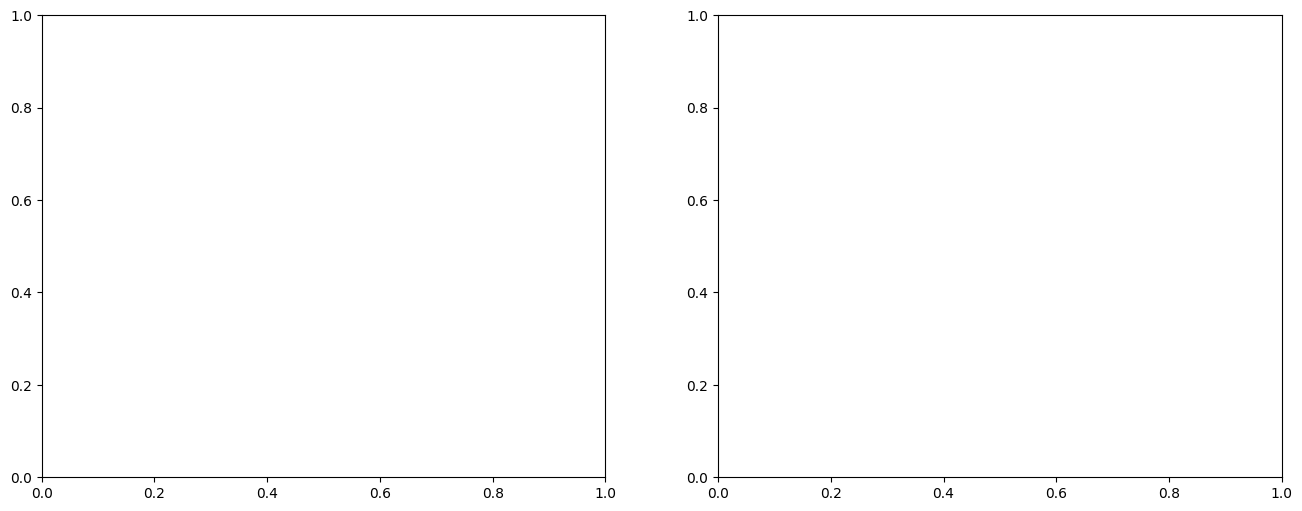

In [ ]:
# Convert to numpy array: (n_classes, n_samples, n_features)
shap_values_all = np.array(shap_values)

# Compute mean SHAP values across classes -> (n_samples, n_features)
mean_shap_vals = np.mean(shap_values_all, axis=0)

# Compute global feature importance
mean_feature_shap = np.mean(np.abs(mean_shap_vals), axis=0)  # (n_features,)
top10_idx = np.argsort(mean_feature_shap)[-10:][::-1]
top10_features = np.array(feature_names)[top10_idx]
top10_values = mean_feature_shap[top10_idx]

# Use matching X sample for plotting
X_shap_sample_flat = X_test[:mean_shap_vals.shape[0]].reshape((mean_shap_vals.shape[0], -1))

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

plt.sca(axes[0])
shap.summary_plot(
    mean_shap_vals,
    X_shap_sample_flat,
    feature_names=feature_names,
    show=False,
    plot_type="dot",
    color_bar=True,
    max_display=10
)
axes[0].set_title("Overall SHAP Summary", fontsize=14)

axes[1].barh(top10_features, top10_values, color='purple')
axes[1].set_title("Top 10 Global Features", fontsize=14)
axes[1].set_xlabel("Mean |SHAP| Value")
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()


In [ ]:
# ======================= Load Data =======================

df_metabolites = pd.read_csv("/content/drive/MyDrive/THESIS/metabolites_training.csv")


Epoch 1/150
112/112 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.3553 - loss: 2.5280 - val_accuracy: 0.6817 - val_loss: 2.1127 - learning_rate: 1.0000e-04
Epoch 2/150
112/112 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.6162 - loss: 1.8151 - val_accuracy: 0.7895 - val_loss: 1.8150 - learning_rate: 1.0000e-04
Epoch 3/150
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.6994 - loss: 1.5634 - val_accuracy: 0.8221 - val_loss: 1.4228 - learning_rate: 1.0000e-04
Epoch 4/150
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7409 - loss: 1.4376 - val_accuracy: 0.8338 - val_loss: 1.1929 - learning_rate: 1.0000e-04
Epoch 5/150
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7548 - loss: 1.3721 - val_accuracy: 0.8417 - val_loss: 1.1097 - learning_rate: 1.0000e-04
Epoch 6/150
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7798 - loss: 1.2861 - val_accuracy: 0.8479 - val_loss: 1.0695 - learning_rate: 1.0000e-04
Epoch 7/150
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/st

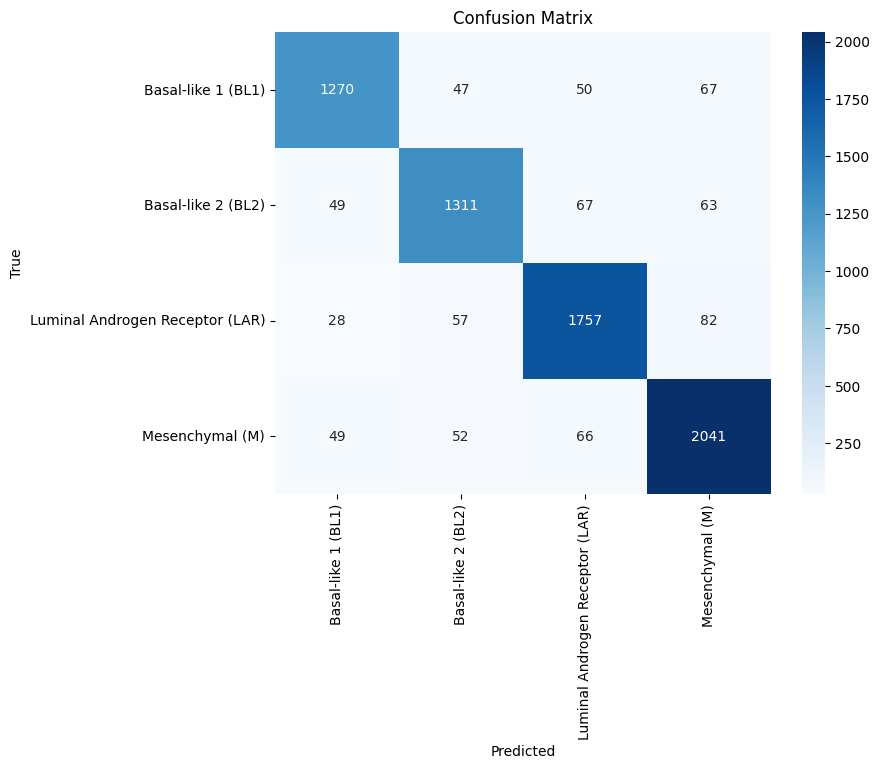

Accuracy: 0.9040532879818595
Precision: 0.904034584091132
Recall: 0.9040532879818595
F1 Score: 0.9039663219119946


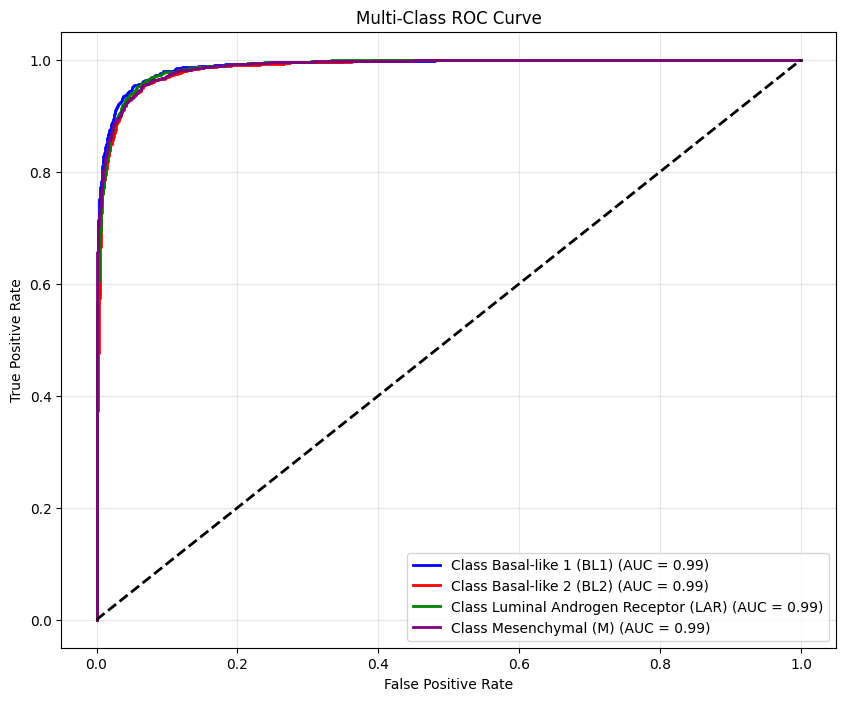


Macro-Averaged AUC: 0.9877


In [ ]:

# ======================= Data Prep =======================
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_metabolites["TNBC_Subtype"])
X = df_metabolites.drop(columns=["TNBC_Subtype"]).values
feature_names = df_metabolites.drop("TNBC_Subtype", axis=1).columns.tolist()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X).astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1])).astype(np.float32)
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1])).astype(np.float32)

# ======================= Model =======================
def lstm(X_train):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001))))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Bidirectional(LSTM(64, return_sequences=False, kernel_regularizer=l2(0.001))))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.3))

    model.add(Dense(len(np.unique(y)), activation='softmax'))

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=Adam(learning_rate=1e-4),
        metrics=['accuracy']
    )
    return model

model = lstm(X_train)

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=150, batch_size=252,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping, lr_scheduler])

# ======================= Evaluation =======================
y_pred = np.argmax(model.predict(X_test), axis=1)
y_pred_proba = model.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt='d',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))

# ROC-AUC
n_classes = len(label_encoder.classes_)
y_test_one_hot = label_binarize(y_test, classes=range(n_classes))
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_one_hot[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'purple', 'orange', 'cyan'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"Class {label_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

macro_auc = roc_auc_score(y_test_one_hot, y_pred_proba, average='macro', multi_class='ovr')
print(f"\nMacro-Averaged AUC: {macro_auc:.4f}")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# ======================= SHAP =======================
X_train_flat = X_train.reshape((X_train.shape[0], -1))
X_test_flat = X_test.reshape((X_test.shape[0], -1))

def predict_fn(x):
    x_reshaped = x.reshape((x.shape[0], 1, X_train.shape[2]))
    return model.predict(x_reshaped)

background = X_train_flat[np.random.choice(X_train_flat.shape[0], 100, replace=False)]
explainer = shap.KernelExplainer(predict_fn, background)

X_shap_sample_flat = X_test_flat[:50]
shap_values = explainer.shap_values(X_shap_sample_flat)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
6832/6832 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
6832/6832 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
6832/6832 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
6832/6832 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
6832/6832 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
6832/6832 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
6832/6832 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6832/6832 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
6832/6832 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
6832/6832 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6832/6832 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6832/6832 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step
1/1 ━━━━━━━━━━━━


Class 0: Basal-like 1 (BL1)


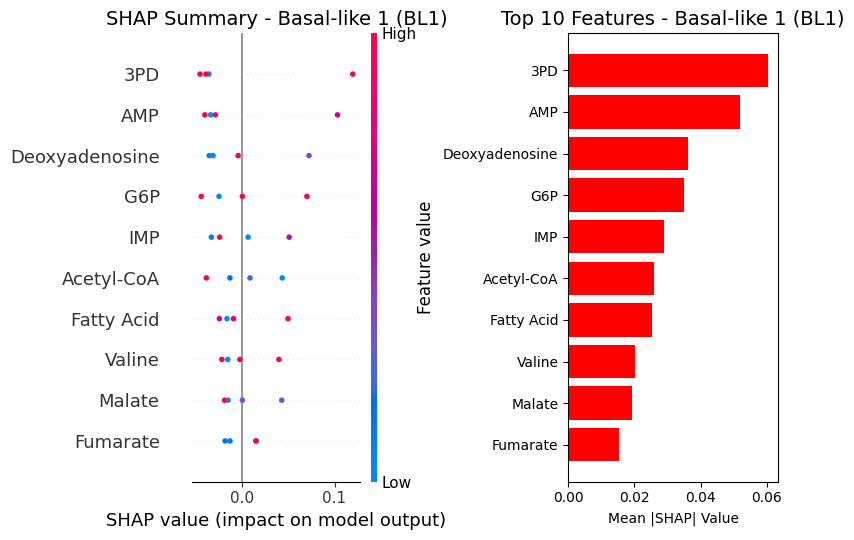


Class 1: Basal-like 2 (BL2)


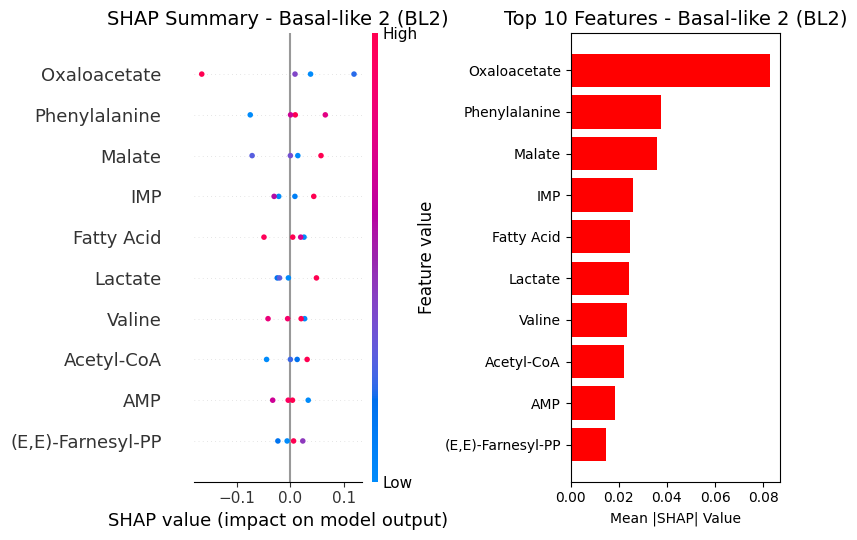


Class 2: Luminal Androgen Receptor (LAR)


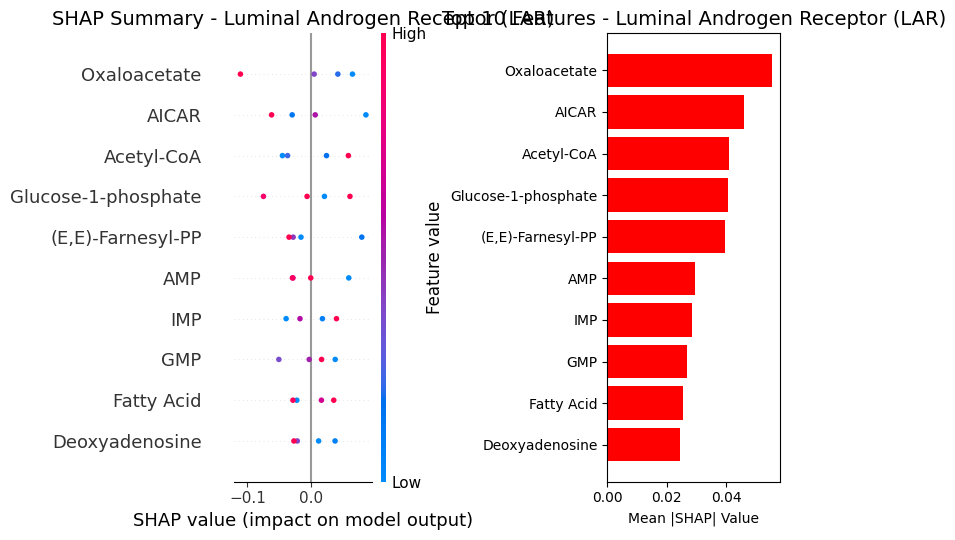


Class 3: Mesenchymal (M)


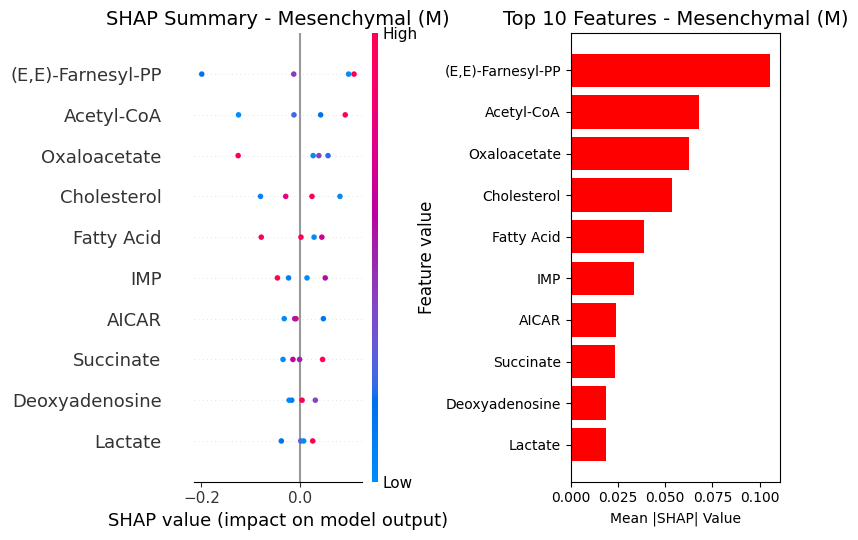

In [ ]:
# ======================= Per-Class SHAP Summary + Features =======================
X_shap_sample = X_test[:4]
X_shap_sample_flat_small = X_shap_sample.reshape((X_shap_sample.shape[0], X_shap_sample.shape[2]))

for i, class_name in enumerate(label_encoder.classes_):
    print(f"\nClass {i}: {class_name}")
    shap_vals = shap_values[i].T

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    plt.sca(axes[0])
    shap.summary_plot(
        shap_vals,
        X_shap_sample_flat_small,
        feature_names=feature_names,
        show=False,
        plot_type="dot",
        color_bar=True,
        max_display=10
    )
    axes[0].set_title(f"SHAP Summary - {class_name}", fontsize=14)

    mean_abs_shap = np.abs(shap_vals).mean(axis=0)
    top10_idx = np.argsort(mean_abs_shap)[-10:][::-1]
    top10_features = np.array(feature_names)[top10_idx]
    top10_values = mean_abs_shap[top10_idx]

    axes[1].barh(top10_features, top10_values, color='red')
    axes[1].set_title(f"Top 10 Features - {class_name}", fontsize=14)
    axes[1].set_xlabel("Mean |SHAP| Value")
    axes[1].invert_yaxis()

    plt.tight_layout()
    plt.show()


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

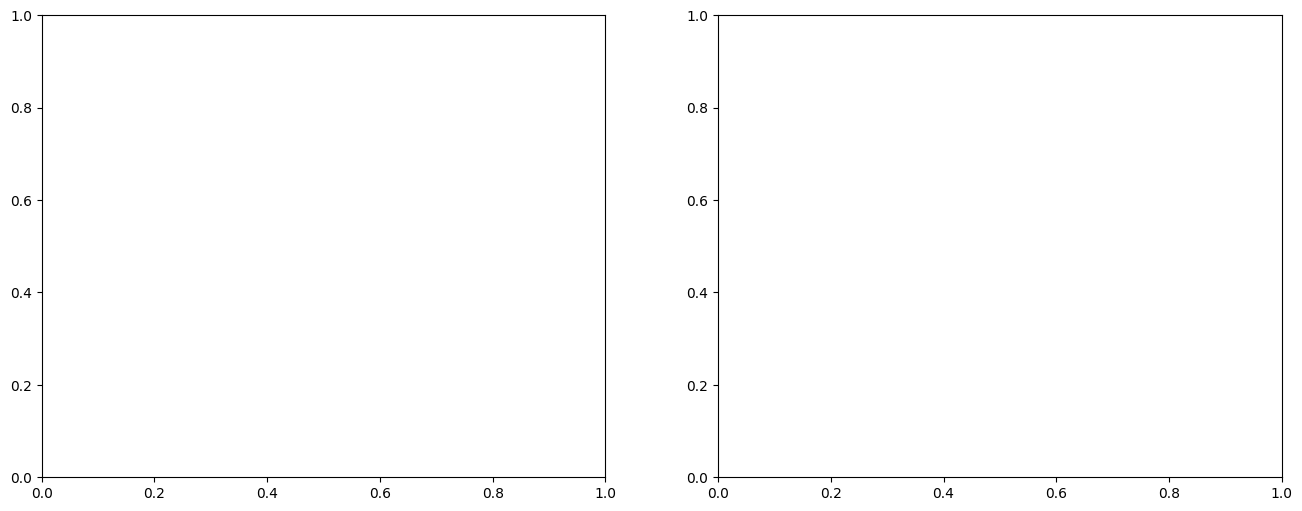

In [ ]:
# ======================= Global SHAP Summary + Top Features =======================

# Convert to numpy
shap_values_all = np.array(shap_values)  # shape: (n_classes, n_samples, n_features)

# Average across classes → shape: (n_samples, n_features)
mean_shap_vals = np.mean(shap_values_all, axis=0)

# Compute mean absolute SHAP values for global importance → shape: (n_features,)
mean_feature_shap = np.mean(np.abs(mean_shap_vals), axis=0)

# Get top 10 feature indices
top10_idx = np.argsort(mean_feature_shap)[-10:][::-1]
top10_features = np.array(feature_names)[top10_idx]
top10_values = mean_feature_shap[top10_idx]

# Plot SHAP summary + bar chart
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ✅ SHAP summary plot (use same 50-sample input used for shap_values)
plt.sca(axes[0])
shap.summary_plot(
    mean_shap_vals,                     # shape: (50, 69)
    X_shap_sample_flat,                # shape: (50, 69)
    feature_names=feature_names,
    show=False,
    plot_type="dot",
    color_bar=True,
    max_display=10
)
axes[0].set_title("Overall SHAP Summary", fontsize=14)

# ✅ Bar plot of top 10 global features
axes[1].barh(top10_features, top10_values, color='purple')
axes[1].set_title("Top 10 Global Features", fontsize=14)
axes[1].set_xlabel("Mean |SHAP| Value")
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()


# ====================== USING UMAP DATAFRAME =======================

In [8]:
# ======================= Load Data =======================

df_UMAP = pd.read_csv("/content/drive/MyDrive/MY THESIS/Thesis/metabolites_umap_training.csv")


Epoch 1/150
112/112 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.5393 - loss: 1.7900 - val_accuracy: 0.8601 - val_loss: 1.8635 - learning_rate: 1.0000e-04
Epoch 2/150
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8908 - loss: 0.9291 - val_accuracy: 0.9422 - val_loss: 1.4341 - learning_rate: 1.0000e-04
Epoch 3/150
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9247 - loss: 0.7956 - val_accuracy: 0.9691 - val_loss: 0.9071 - learning_rate: 1.0000e-04
Epoch 4/150
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9332 - loss: 0.7361 - val_accuracy: 0.9765 - val_loss: 0.6671 - learning_rate: 1.0000e-04
Epoch 5/150
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9408 - loss: 0.6876 - val_accuracy: 0.9823 - val_loss: 0.5883 - learning_rate: 1.0000e-04
Epoch 6/150
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9453 - loss: 0.6530 - val_accuracy: 0.9836 - val_loss: 0.5527 - learning_rate: 1.0000e-04
Epoch 7/150
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/ste

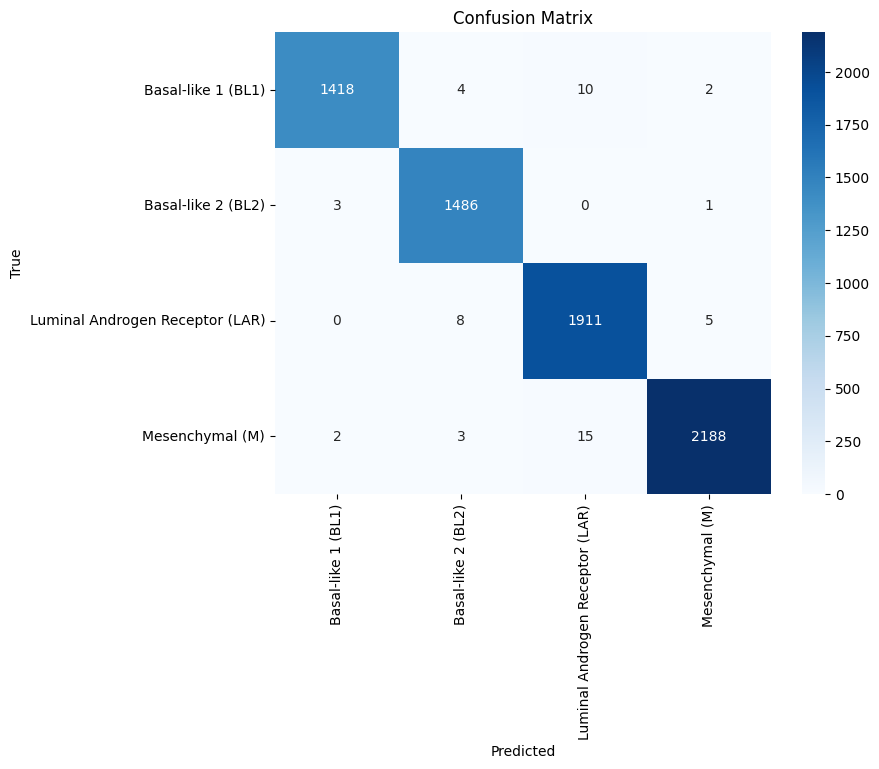

Accuracy: 0.9924886621315193
Precision: 0.9925145293095715
Recall: 0.9924886621315193
F1 Score: 0.9924908491135167


NameError: name 'label_binarize' is not defined

In [9]:

# ======================= Data Prep =======================
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_UMAP["TNBC_Subtype"])
X = df_UMAP.drop(columns=["TNBC_Subtype"]).values
feature_names = df_UMAP.drop("TNBC_Subtype", axis=1).columns.tolist()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X).astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1])).astype(np.float32)
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1])).astype(np.float32)

# ======================= Model =======================
def lstm(X_train):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001))))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Bidirectional(LSTM(64, return_sequences=False, kernel_regularizer=l2(0.001))))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.3))

    model.add(Dense(len(np.unique(y)), activation='softmax'))

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=Adam(learning_rate=1e-4),
        metrics=['accuracy']
    )
    return model

model = lstm(X_train)

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=150, batch_size=252,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping, lr_scheduler])

# ======================= Evaluation =======================
y_pred = np.argmax(model.predict(X_test), axis=1)
y_pred_proba = model.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt='d',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))

# ROC-AUC
n_classes = len(label_encoder.classes_)
y_test_one_hot = label_binarize(y_test, classes=range(n_classes))
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_one_hot[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'purple', 'orange', 'cyan'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"Class {label_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

macro_auc = roc_auc_score(y_test_one_hot, y_pred_proba, average='macro', multi_class='ovr')
print(f"\nMacro-Averaged AUC: {macro_auc:.4f}")